<a href="https://colab.research.google.com/github/geraschenko/gmrfs/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install libsuitesparse-dev
!pip install -q git+https://github.com/geraschenko/gmrfs.git

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'  # IMPORTANT!

import networkx as nx
from gmrfs import sparse
from gmrfs import gmrf
from gmrfs import inla

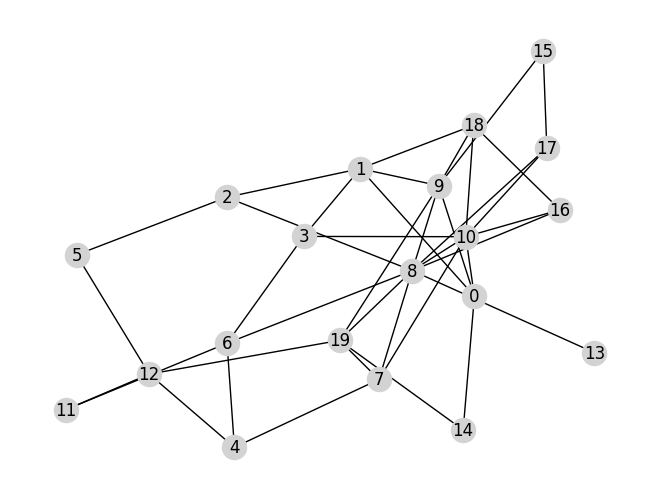

In [4]:
rng = np.random.default_rng(seed=2)

n = 20
graph = nx.binomial_graph(n, 0.2, seed=1, directed=False)
nx.draw(graph, with_labels=True, node_color = 'lightgray')

num_covariates = 1
covariates = np.abs(rng.normal(scale = 0.4, size=(n, num_covariates)))

gmrf_model = gmrf.IntrinsicConditionalAutoregressive(graph, covariates)
gmrf_model.sparsity_structure.jit_me()  # jits sparse cholesky factorization, triangular solves, etc.

In [5]:
#@title Pick ground truth parameters and simulate from them
taus = np.linspace(.5, 2.5, 71)
betas = np.linspace(1.5, 5.5, 101)
tau, beta = np.meshgrid(taus, betas)
params = (tau, beta[..., jnp.newaxis])
extent = (taus.min(), taus.max(), betas.min(), betas.max())  # for plots

true_i, true_j = 50, 35
true_params = (params[0][true_i, true_j], params[1][true_i, true_j])
true_gaussian = gmrf_model(true_params)
num_samples = 50
sample_key = jax.random.PRNGKey(0)
true_x = jax.vmap(true_gaussian.sample)(jax.random.split(sample_key, num_samples))
y = rng.poisson(np.exp(true_x))

print(f'true parameter values: {true_params}')
print(f'true poisson means: {np.exp(true_x[0])}')
print(f'sample counts: {y[0]}')

true parameter values: (1.5, array([3.5]))
true poisson means: [ 1.0981013   1.0643375   1.7040466  10.890152    6.7068706   8.864728
  1.0607034   2.4968677   1.0926036   1.1566808   2.4990225   1.2189169
  1.3088987  13.201669    1.926136    0.53023314  0.8161108   1.5358584
  0.47872084  2.5249345 ]
sample counts: [ 1  2  3  6 14  5  2  4  0  0  1  0  1 13  4  1  1  2  0  2]


In [6]:
#@title Define the INLA instance

def log_poisson_likelihood(x, y):
  """log(p(y|x))"""
  return jax.scipy.stats.poisson.logpmf(y, jnp.exp(x))

inla_model = inla.Inla(gmrf_model=gmrf_model,
                       measurement_log_prob_fn=log_poisson_likelihood)

In [7]:
# Runtime asserts must be turned off to vmap
inla_model.gmrf_model.sparsity_structure.do_asserts = False

# This timing was with a GPU kernel.
%time likelihoods = jax.vmap(jax.vmap(jax.vmap(inla_model.log_marginal_likelihood, in_axes=(0, None)), in_axes=(0, None)), in_axes=(None, 0))(params, y)

CPU times: user 17.2 s, sys: 339 ms, total: 17.5 s
Wall time: 23.6 s


In [8]:
likelihoods.shape, tau.shape

((50, 101, 71), (101, 71))

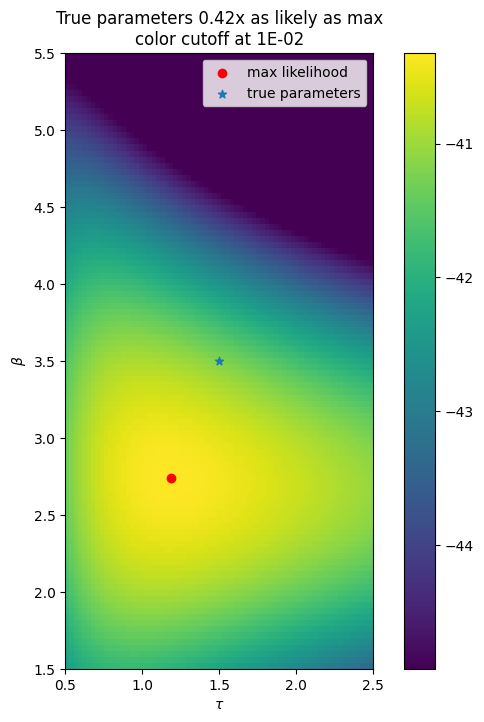

In [9]:
#@title Belief based on one sample, compared to true parameters
plt.figure(figsize=(8, 8))
likelihood = likelihoods[0]
vmax = likelihood.max()
vmin = vmax - np.log(100)
plt.imshow(likelihood, extent=extent, vmin=vmin, vmax=vmax)
plt.colorbar()
i, j = np.unravel_index(np.argmax(likelihood), likelihood.shape)
plt.scatter([params[0][i, j]], [params[1][i, j]], c='r', label='max likelihood')
plt.scatter([true_params[0]], [true_params[1]], marker='*', label='true parameters')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\beta$')
factor = np.exp(likelihood[true_i, true_j] - likelihood[i, j])
plt.title(f'True parameters {factor:.2f}x as likely as max\ncolor cutoff at {np.exp(vmin - vmax):.0E}')
plt.legend()
plt.show()

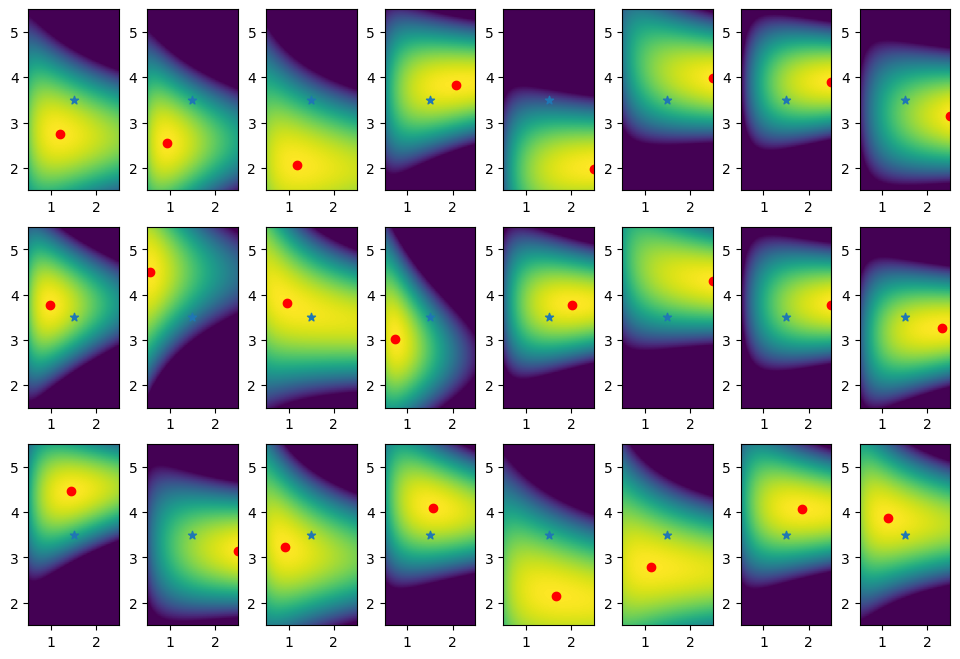

In [10]:
#@title Beliefs based on single samples, compared to true parameters
fig, axes = plt.subplots(3, 8, figsize=(12, 8))
for ax, likelihood in zip(axes.ravel(), likelihoods):
  i, j = np.unravel_index(np.argmax(likelihood), likelihood.shape)
  vmax = likelihood.max()
  vmin = vmax - np.log(100)
  ax.imshow(likelihood, extent=extent, vmin=vmin, vmax=vmax)
  ax.scatter([params[0][i, j]], [params[1][i, j]], c='r')
  ax.scatter([true_params[0]], [true_params[1]], marker='*')

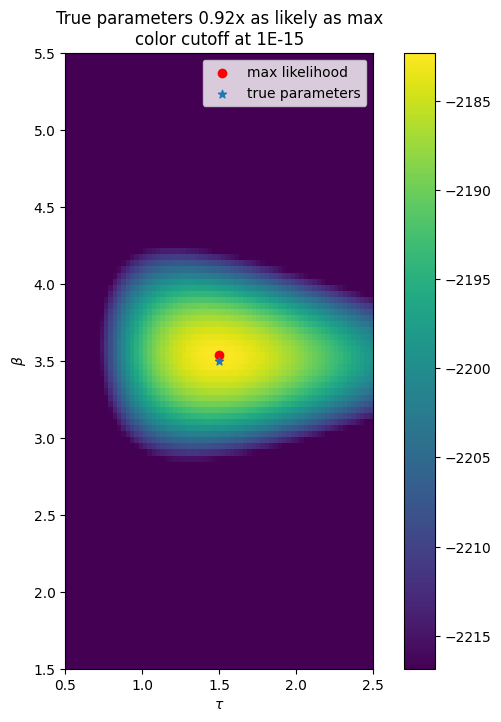

In [11]:
#@title Belief based on all samples, compared to true parameters
plt.figure(figsize=(8, 8))
likelihood = likelihoods.sum(axis=0)
vmax = likelihood.max()
vmin = vmax - 15 * np.log(10)
plt.imshow(likelihood, extent=extent, vmin=vmin, vmax=vmax)
plt.colorbar()
i, j = np.unravel_index(np.argmax(likelihood), likelihood.shape)
plt.scatter([params[0][i, j]], [params[1][i, j]], c='r', label='max likelihood')
plt.scatter([true_params[0]], [true_params[1]], marker='*', label='true parameters')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\beta$')
factor = np.exp(likelihood[true_i, true_j] - likelihood[i, j])
plt.title(f'True parameters {factor:.2f}x as likely as max\ncolor cutoff at {np.exp(vmin - vmax):.0E}')
plt.legend()
plt.show()
